# practicalMixGaussC

The goal of this part of the lab is to fit a mixture of gaussians model to some multi-dimensional data. To do this, we will first generate some data from a known mixture of gaussians model and fit our own mixture of gaussians model to the generated data. The parameters from our estimated mixture of gaussians model should roughly match those of the original known model. 

Note that you should not use multivariate_normal.pdf for calculating likelihood.

You should use this template for your code and fill in the missing 
sections marked "TO DO."



In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from scipy.stats import norm 
from scipy.stats import multivariate_normal
import time
import sys

from numpy import sqrt, pi, exp, transpose, matmul
from numpy.linalg import det, inv

flt_min = sys.float_info.min

%matplotlib inline # if this was just 'notebook' the plots would not appear, only text output.

UsageError: unrecognized arguments: # if this was just 'notebook' the plots would not appear, only text output.


## Construct Ground Truth Mixture of Gaussians Model and Plot Some Points

Define some true parameters for our ground truth mixture of $k$ Gaussians model. We will represent the 
mixtures of Gaussians as a python dictionary. The mean field is a $d \times k$ matrix and the cov field is a 
$d \times d \times k$ matrix.

In [2]:
mixGaussTrue = dict()
mixGaussTrue['k'] = 3
mixGaussTrue['d'] = 2
mixGaussTrue['weight'] = np.array([0.1309, 0.3966, 0.4725])
mixGaussTrue['mean'] = np.array([[ 4.0491 , 4.8597],[ 7.7578 , 1.6335],[ 11.9945, 8.9206]]).T
mixGaussTrue['cov'] = np.reshape([0.5, 0.25], newshape=(1,1,2))
mixGaussTrue['cov'] = np.zeros(shape=(mixGaussTrue['d'],mixGaussTrue['d'],mixGaussTrue['k']))
mixGaussTrue['cov'][:,:,0] = np.array([[  4.2534, 0.4791], [0.4791, 0.3522]])
mixGaussTrue['cov'][:,:,1] = np.array([[  0.9729, 0.8723],[  0.8723,  2.6317]])
mixGaussTrue['cov'][:,:,2] = np.array([[  0.9886, -1.2244],[ -1.2244, 3.0187]])

**drawEMData2d**, **sampleFromDiscrete**, **getGaussian2SD**, and **drawGaussianOutline** are helper functions.

In [3]:
def sampleFromDiscrete(probDist):     
    """
    Draws a random sample from a discrete probability distribution using a rejection sampling method.  
    
    Keyword arguments:
    probDist -- discrete probability ditrubtion to sample from.
    
    Returns: 
    r -- sampled point.
    """
    nIndex = len(probDist)                                                                 
    while True:                                                                            
        #choose random index                                                               
        r=int(np.floor(np.random.uniform()*nIndex))                                        
        #choose random height                                                              
        randHeight = np.random.uniform()                                                   
        #if height is less than probability value at this point in the                     
        # histogram then select                                                            
        if randHeight<probDist[r]:                                                         
            break                                                                          
    return r                                                                               

In [4]:
# Understand what sampleFromDiscrete does:
h = sampleFromDiscrete(mixGaussTrue['weight']) 
# now h is either 0, 1 or 2, becauase we have 3 classes in the distribution (i.e. 3 gaussians to choose from)

# Understand the indexing to access the means and covariances of each gaussian from the dictionary:
print(mixGaussTrue['mean'][:,0]) # the multivariate means for each gaussian are stored as column vectors, and you can access them like this.
print(mixGaussTrue['cov'][:,:,0]) # the covariances for each gaussian can be accessed like this.

[4.0491 4.8597]
[[4.2534 0.4791]
 [0.4791 0.3522]]


In [5]:
def getGaussian2SD(m,s,angle1):
    """
    Find position of in xy co-ordinates at 2SD out for a certain angle.
    """
  
    if s.shape[1] == 1:
        s = np.diag(s)

    vec = np.array([np.cos(angle1), np.sin(angle1)])
    
    factor = 4/(vec@np.linalg.inv(s)@vec.T)
    
    x = np.cos(angle1) * np.sqrt(factor)
    y = np.sin(angle1) * np.sqrt(factor)

    x = x + m[0]
    y = y + m[1]
                
    return x,y

In [6]:
def drawGaussianOutline(m,s,w):
    """
    Draw 2DGaussian
    """
    angleInc = 0.1    
    c = (0.9*(1-w), 0, 0)

    for cAngle in np.arange(0,2*np.pi,angleInc):         
        angle1 = cAngle
        angle2 = cAngle+angleInc
        x1, y1 = getGaussian2SD(m,s,angle1)
        x2, y2 = getGaussian2SD(m,s,angle2)
        plt.plot([x1, x2],[y1, y2],'-',linewidth=2,color=c)                 
    return

In [7]:
def drawEMData2d(data,mixGauss):
    """
    Plot the data plot the mixtures of Gaussian model, mixGauss, on top of it.
    
    Keyword arguments:
    data -- d by n matrix of data points.
    mixGauss -- dict with mixture of gaussian information.
    
    """
    #set(gcf,'Color',[1 1 1])
    plt.cla() 
    plt.plot(data[0,:],data[1,:],'k.')

    for cGauss in range(mixGauss['k']):
        drawGaussianOutline(mixGauss['mean'][:,cGauss],mixGauss['cov'][:,:,cGauss],mixGauss['weight'][cGauss])
    
    return     


**TODO H HERE:**

Complete the TO DO in this function before moving on.

In [8]:
def mixGaussGen(mixGauss, nData):                                                                              
    """
    Generates data from a d-dimensional mixture of Gaussians model. 
    
    Keyword arguments:
    mixGauss -- dict containing the mixture of gaussians arguments.
    nData -- number of data points to generate.
    
    Returns: 
    data -- d by nData, generated data points. 
    
    """
    # create space for output data                                                                               
    data = np.zeros(shape=(mixGauss['d'], nData))                                                                            
    # for each data point                                                                                        
    for cData in range(nData):                                                                                   
        # randomly choose Gaussian according to probability distributions                                        
        h = sampleFromDiscrete(mixGauss['weight'])                                                               
        # draw a sample from the appropriate Gaussian distribution  
        # first sample from the covariance matrix (google how to do this - it
        # will involve the numpy function np.linalg.cholesky().  Then add the mean vector
        # TO DO (h)- insert data generation code here:
        data[:,cData] = mixGauss['mean'][:,h] + np.linalg.cholesky(mixGauss['cov'][:,:,h]) @ np.random.normal(size=2)

        # Why can't we just use np.random.multivariate_normal(mean, cov)??
        # data[:,cData] = np.random.multivariate_normal(mixGauss['mean'][:,h], mixGauss['cov'][:,:,h])  
                                                                                                         
    return data

With all the helper functions complete, we can now generate and plot some points from our model. The black points are the generated data points. The circles are what the gaussians look like.

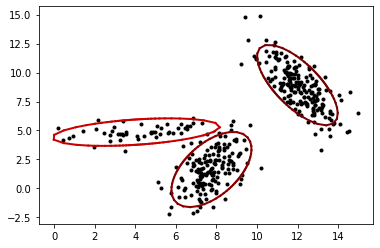

In [9]:
#define number of samples to generate
nData = 400

#generate data from the mixture of Gaussians
#make sure you've filled in the routine above.
data = mixGaussGen(mixGaussTrue,nData)

#draw data, true Gaussians
drawEMData2d(data,mixGaussTrue)

This plot shows the three clusters of data generated from the three gaussian distributions specified in the true mixture of gaussians.

## Estimate MoG using the E-M Algorithm
Here we want to use the E-M algorithm to fit a MoG model to our data points. 

**TODO I HERE:** 

Fill out the missing parts below. 

The log likelihood is taken since the raw likelihood value could be too small for our machine's percision.

In [10]:
#the goal of this routine is to evaluate a Gaussian likelihood
def getGaussProb(data,gaussMean,gaussCov):
    """
    Returns the likelihood that each data point in data belongs to the Gaussian described by gaussMean and 
    gaussCov.
    
    Keyword arguments:
    data -- d by 1 matrix of one data point. d is the number of dimensions of that data point
    gaussMean -- d by 1 vector containing the mean parameter of the Gaussian distribution.
    gaussCov -- d by d matrix containing the covariance parameters of the Gaussian distribution.
    
    Returns: 
    like -- 1 by n vector contianing the likelihood that each data point in data belongs to the Gaussian 
    distribution defined by gaussMean and gaussCov.
    """
    nDim = data.shape[0]
    
    #TO DO (b) - fill in this routine, replace the placeholders for like with the actual equation.
    
    like = 1/((2*pi)**(nDim/2)) * det(gaussCov)**(-1/2) * exp(-0.5 * (np.expand_dims(data-gaussMean,1).T @ inv(gaussCov) @ (np.expand_dims(data-gaussMean,1))))

    return like.item()

In [11]:
# TRIALS

x = np.array([[1,3],[5,2],[4,1]]).T
thisdata = x[:,0]
thismean = mixGaussTrue['mean'][:,0]
thiscov = mixGaussTrue['cov'][:,:,0]

print(thisdata)
print(thismean)
print(np.expand_dims(thisdata,1))

print(getGaussProb(thisdata, thismean, thiscov))
multivariate_normal.pdf(thisdata, thismean, thiscov)


[1 3]
[4.0491 4.8597]
[[1]
 [3]]
0.0010036909687124148


0.0010036909687124141

In [12]:
def getMixGaussLogLike(data, mixGaussEst): 
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    logLike -- scalar containing the log likelihood.
    
    """
    
    data = np.atleast_2d(data)                                                                         
    # find total number of data items                                                                  
    nDims, nData = data.shape                                                                          
    
    # initialize log likelihoods                                                                       
    logLike = 0;                                                                                       
                                                                                                       
    # run through each data item                                                                       
    for cData in range(nData):                                                                         
        thisData = data[:, cData]                                                                      
        # TO DO (i)- calculate likelihood of this data point under mixture of                         
        # Gaussians model. Replace this                                                                
        like = 0
        
        for k in range(mixGaussEst['k']):
            lam = mixGaussEst['weight'][k]
            mu = mixGaussEst['mean'][:,k]
            covar = mixGaussEst['cov'][:,:,k]
            like += lam * getGaussProb(thisData, mu, covar)
        
        # add to total log like                                                                        
        logLike = logLike + np.log(like)                                                               
                                                                                                       
    return  logLike.item() # np.asscalar(logLike) -- this modification was suggested when I ran the code                                                                      
                                                                                                       

In [13]:
# This function will be useful. Turns vectors of dimension (d,) into (d,1)
def col(x):
    return np.expand_dims(x,1)

**TODO J HERE:** 

Fill out the missing parts below. 

In [14]:
def fitMixGauss(data, k):
    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    
    nDims, nData = data.shape


    postHidden = np.zeros(shape=(k, nData)) # responsibilities

    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['k'] = k
    mixGaussEst['d'] = nDims
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
        
    
    # calculate current likelihood
    # TO DO (j) starts here - fill in this routine
    logLike = getMixGaussLogLike(data, mixGaussEst)
    print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))

    nIter = 30

    logLikeVec = np.zeros(shape=(2 * nIter))
    boundVec = np.zeros(shape=(2 * nIter))

    fig, ax = plt.subplots(1, 1)

    # Plot initial conditions
    drawEMData2d(data, mixGaussEst)
    time.sleep(0.7)
    fig.canvas.draw()
    plt.show()

    for cIter in range(nIter):

        # ===================== =====================
        # Expectation step
        # ===================== =====================
        
        curCov = mixGaussEst['cov']                                                                                  
        curWeight = mixGaussEst['weight']                                                                            
        curMean = mixGaussEst['mean'] 

        for cData in range(nData):
            # TO DO : fill in column of 'hidden' - calculate posterior probability that
            # this data point came from each of the Gaussians
            # replace this:
            thisData = data[:, cData]
            
            for cGauss in range(k):
                postHidden[cGauss, cData] = curWeight[cGauss] * getGaussProb(thisData, curMean[:,cGauss], curCov[:,:,cGauss])                                                                                        
            
            postHidden[:, cData] = postHidden[:, cData] / np.sum(postHidden[:, cData])
            
            

        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        # for each constituent Gaussian
        for cGauss in range(k):
            # TO DO :  Update weighting parameters mixGauss.weight based on the total
            # posterior probability associated with each Gaussian. Replace this:

            mc = np.sum(postHidden[cGauss,:]) 

            mixGaussEst['weight'][cGauss] = mc / nData
            
            
            # TO DO :  Update mean parameters mixGauss.mean by weighted average
            # where weights are given by posterior probability associated with
            # Gaussian.  Replace this:
            mixGaussEst['mean'][:,cGauss] = (1/mc) * np.sum(postHidden[cGauss,:] * data, 1)
            
            
            # TO DO :  Update covarance parameter based on weighted average of
            # square distance from update mean, where weights are given by
            # posterior probability associated with Gaussian
            # '''
            sum_C = 0
            
            for cData in range(nData):
                C = postHidden[cGauss,cData] * col(data[:,cData] - mixGaussEst['mean'][:,cGauss]) @ (col(data[:,cData] - mixGaussEst['mean'][:,cGauss]).T)
                sum_C = sum_C + C

            mixGaussEst['cov'][:,:,cGauss] = (1/mc) * sum_C
            # '''
            

            # mixGaussEst['cov'][:,:,cGauss] = (1/mc) * (postHidden[cGauss,:]*(data - col(mixGaussEst['mean'][:,cGauss]))) @ (data - col(mixGaussEst['mean'][:,cGauss])).T

        # draw the new solution
        
        drawEMData2d(data, mixGaussEst)
        time.sleep(0.7)
        fig.canvas.draw()
        #plt.show()

        # calculate the log likelihood
        logLike = getMixGaussLogLike(data, mixGaussEst)
        print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter, logLike))


    return mixGaussEst

### Time to put it all together!

Make sure you've filled all the TO DOs above! 

Log Likelihood Iter 0 : -7199.828



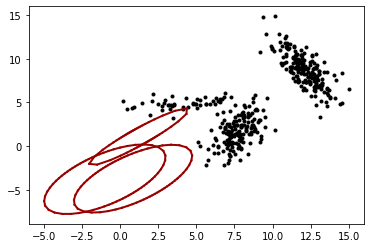

Log Likelihood After Iter 0 : -1953.461

Log Likelihood After Iter 1 : -1947.977

Log Likelihood After Iter 2 : -1946.467

Log Likelihood After Iter 3 : -1945.500

Log Likelihood After Iter 4 : -1944.558

Log Likelihood After Iter 5 : -1943.367

Log Likelihood After Iter 6 : -1941.505

Log Likelihood After Iter 7 : -1937.978

Log Likelihood After Iter 8 : -1929.582

Log Likelihood After Iter 9 : -1898.266

Log Likelihood After Iter 10 : -1820.120

Log Likelihood After Iter 11 : -1758.177

Log Likelihood After Iter 12 : -1716.886

Log Likelihood After Iter 13 : -1667.626

Log Likelihood After Iter 14 : -1611.164

Log Likelihood After Iter 15 : -1601.866

Log Likelihood After Iter 16 : -1601.825

Log Likelihood After Iter 17 : -1601.816

Log Likelihood After Iter 18 : -1601.814

Log Likelihood After Iter 19 : -1601.813

Log Likelihood After Iter 20 : -1601.813

Log Likelihood After Iter 21 : -1601.813

Log Likelihood After Iter 22 : -1601.813

Log Likelihood After Iter 23 : -1601.813

Lo

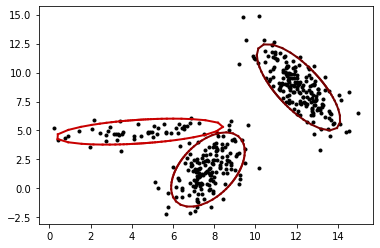

In [15]:
#define number of components to estimate
nGaussEst = 3

#fit mixture of Gaussians (Pretend someone handed you some data. Now what?)
#TO DO fill in this routine (below)
mixGaussEst = fitMixGauss(data,nGaussEst)

As described at the end of practicalMixGaussB, here the EM algorithm converges to find the three gaussians that represent the 3 data clusters produced from the true mixture of gaussians. The estimated distribution is very similar to the true one, and differently to the 2D case, this time the covariances are also similar to the true ones.

The only thing to note is that in some runs, when the initial conditions were really bad, i.e. one or more of the gaussians had very poor parameters (the gaussian was very skewed due to the covariance), then the solution did not converge properly. Therefore, initialisation is very important in these problems, not only for covariances, but also means. If the initial means are too far off from the data clusters, the gaussians might get distracted by outliers and converge to them instead (focusing on single data points instead of clusters), which would result in the wrong solution. This is where t-distributions would be useful.